In [1]:
# Library

from skimage.io import imread,imsave,imshow
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm


# 3 folders 

*  testing_data : I guess it's just to plot images and see few things
*  training_data -> folder with images to train the neural network. 
All = Acute lymphoblastic leukemia
*  validation_data -> folder with images to test the model


# Testing data

First, let's plot some data, check the size of each data,...

In [179]:
#number of images : 2586 (from 1 to 2586)
n = 2586
from skimage.io import imread

path = "C:\\Users\\cossa\\Documents\\ULB\\MA1\\Projet\\ProjetMA1\\C-NMC_Leukemia\\testing_data\\C-NMC_test_final_phase_data\\"
# path = "C:\\Users\\cossa\\Documents\\TEST\\"


# data = open("C:\\Users\\miche\\Documents\\school\\jaar2\\MIK\\2.6\\vektis_agb_zorgverlener")


vec =  [0,0,0]

for x in range (1, n+1):
    seq = imread(path +str(x) + ".bmp")
    for y in range (3):
        vec[y] = vec[y] + seq.shape[y]

        

print  ("Shape : ",vec)



Shape :  [1551600, 1551600, 7758]


In [180]:
for x in range (len(vec)):
    vec[x] = vec[x]/n
    
print  ("Shape : ",vec)

#OUTPUT : 600,600,3 On a donc bien des images 600 * 600 * 3 

Shape :  [600.0, 600.0, 3.0]


Let's check a bit the data, check if we can maybe preprocess something...
Let's plot 50 random data

<ipython-input-83-eefc5e5956f7>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


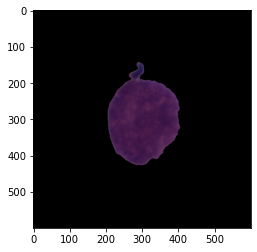

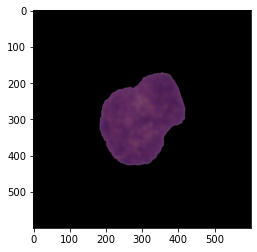

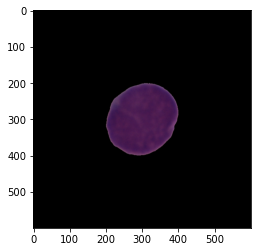

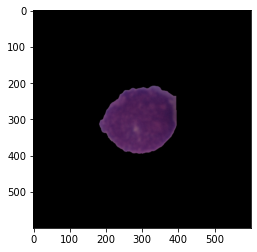

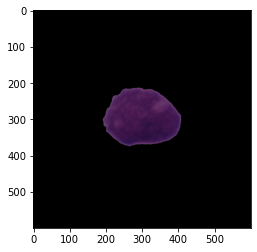

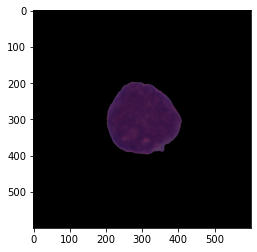

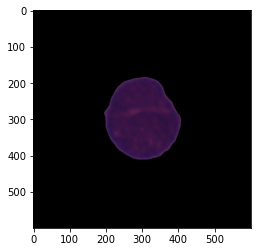

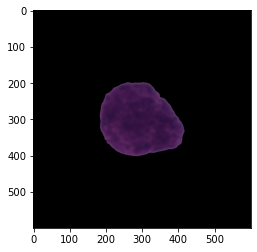

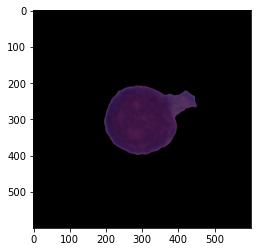

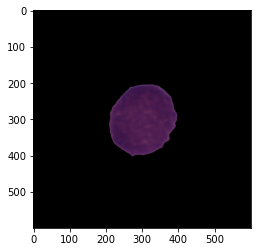

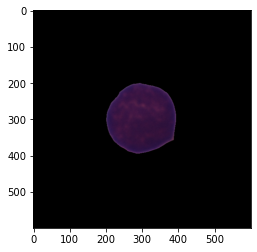

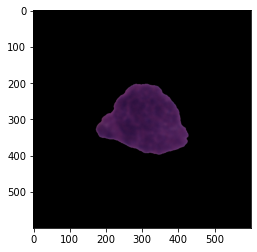

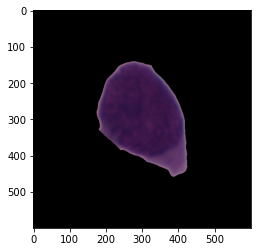

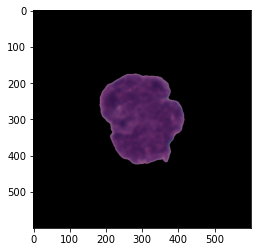

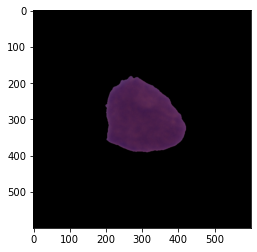

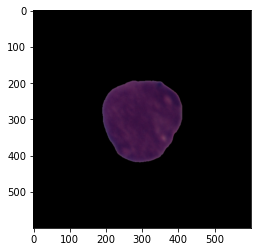

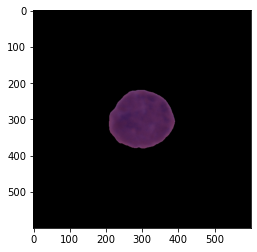

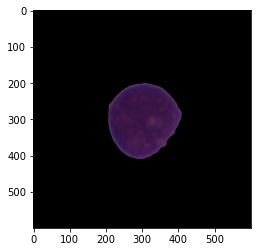

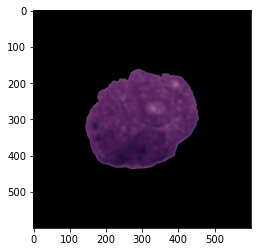

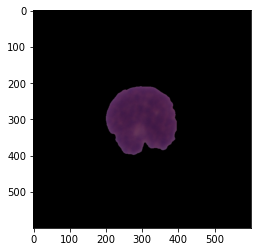

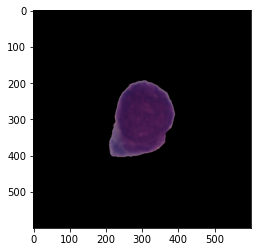

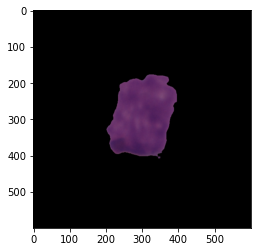

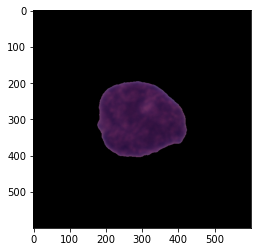

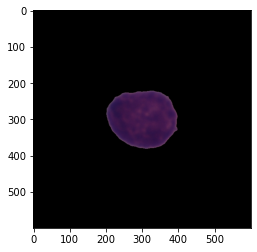

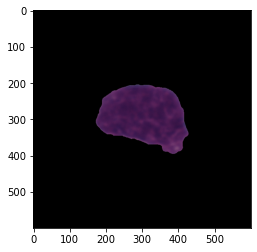

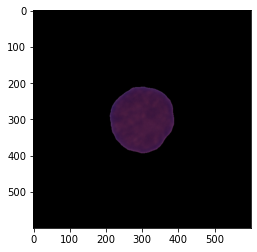

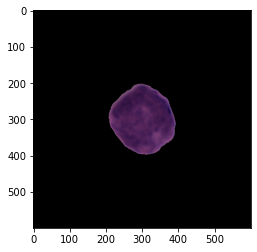

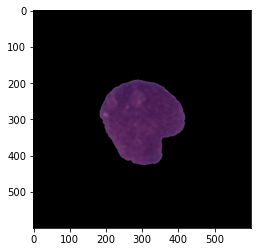

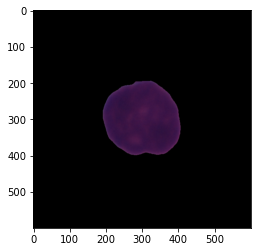

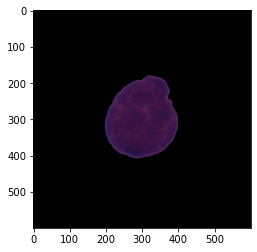

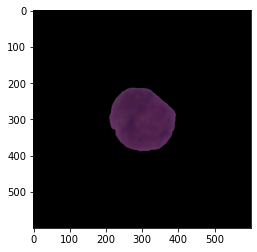

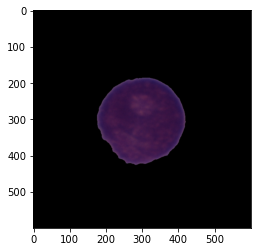

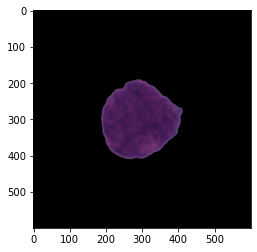

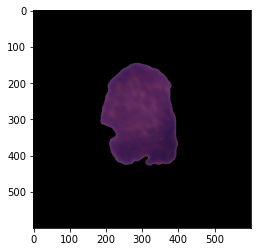

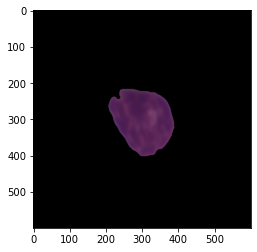

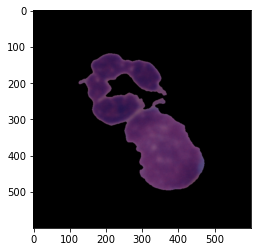

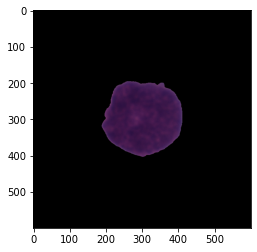

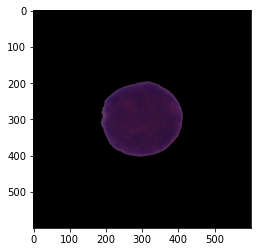

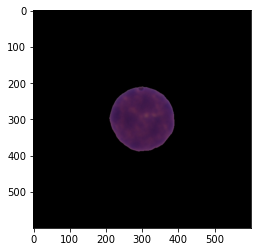

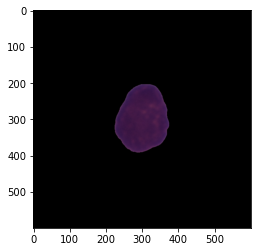

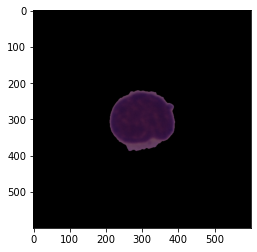

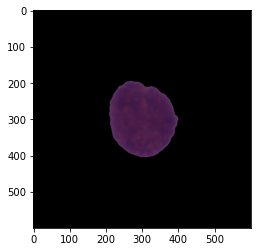

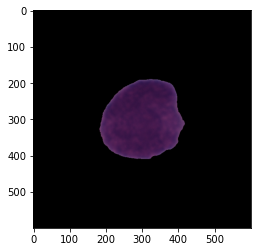

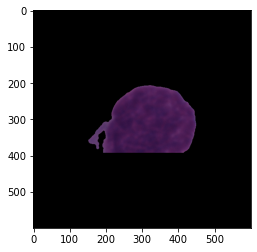

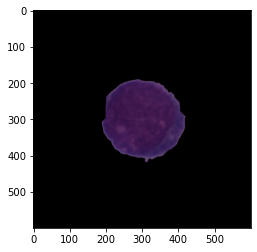

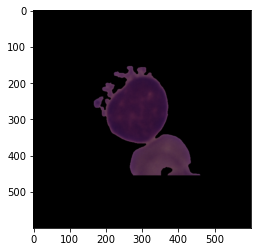

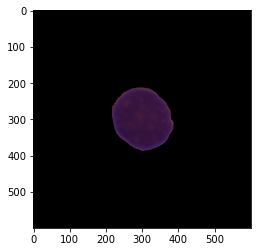

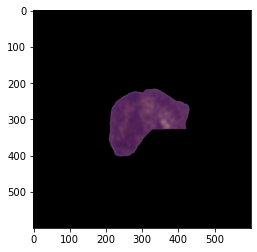

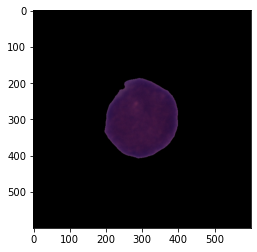

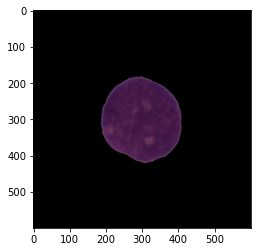

In [83]:
n_r = 50
random_n = np.random.rand(50) * n
random_n = random_n.astype(np.int)


for x in range (1,len(random_n)+1):
    seq = imread(path + str(x) +".bmp")
    plt.figure()
    plt.imshow(seq)

### First conclusion : we can see that generally the usefull information is concentrated in x between 150 and 450 and in y between 150 and 450. So basically there is a lot of pixels we don't need. 

Let's calculate how much pixels we could remove with first impression in order to reduce the size of the image. 
We need a rectangle of (450 - 150) in x and (450-150) in y.

In [86]:
n_total_pixel = 600 * 600 * 3

n_compressed_pixel = 300 * 300 * 3

gain = n_total_pixel / n_compressed_pixel


print ("total pixel", n_total_pixel)
print ("compressed pixel", n_compressed_pixel)
print("gain",gain)


total pixel 1080000
compressed pixel 270000
gain 4.0


### So we actually could have 4 less pixels if we make that cut in the image. BUT maybe there is some important information at some pixel in the black area of the pictures, so let's make some average calculation to see if it is really important or not. 

First of all, let's try to 
-draw 3 histo (with average cell)
-make a border for the cell and try to see what is the maximum amount of pixel we can cut

In [189]:
#Histo 
#As I'll work with average, I'll just put the data between 0 and 1 to not lose any pixel in division (int(0.4)=0... we lose information)
n = 2586
seq = np.zeros(3)
for x in range (1, n+1):
    seq2 = imread(path + str(x) +".bmp")/256
    seq = seq + seq2

    
    
seq_average = (seq/n)


In [190]:
import sys
np.set_printoptions(threshold=sys.maxsize)


Plot average

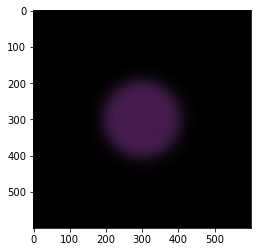

In [193]:
# seq_average = seq_average.astype(np.int) (if between 0 - 255)
plt.figure()
plt.imshow(seq_average, label='average')

0.02728937064965197
70.5703125


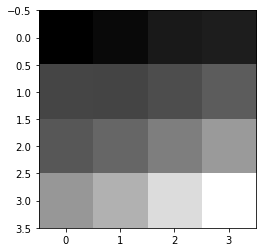

In [200]:
print (seq_average[180,250,0])
print(seq[180,250,0])
seq_check = seq_w[200:400, 200:400,0]

plt.figure()

plt.imshow(seq_average[178:182, 248:252,0], cmap=cm.gray)

#put a choosen borders, use [150:450, 150,450] and check pixel (11) (150,450) (150,150) (450,150) and if all black take image. 
#it should only remove a few outliers

I noticed that an image (246) has pixel different than black at 180,250 and average images don't have. I let the pixel value
between 0 and 1 to not lose this information. We can see that pixel value at 180,250 is 0.027, so very low. Let's see what is the lowest value.

In [199]:
seq_average_flatten = seq_average.flatten()
print(min(seq_average_flatten))

m = min(i for i in seq_average_flatten if i > 0)
print(m)
#OUTPUT = 1.51053*10e-6 --> So there is very low pixel
print (m*256) # OUTPUT = 0.000386 ; if I didn't work with average I would have this value ! 

0.0
1.5105375096674401e-06
0.0003866976024748647


In [235]:
def arrayHist(x):
    hist,bins = np.histogram(x.flatten(),range(256))  # histogram is computed on a 1D distribution --> flatten()
    return hist
def arrayHistNormalized(x):
    hist,bins = np.histogram(x.flatten(),range(0,1))  # histogram is computed on a 1D distribution --> flatten()
    return 1.*hist/np.sum(hist)
def f_plot(x,y,z):
    plt.figure()
    plt.plot(x, label=y, color = z)
    plt.legend(loc='best')
    plt.show()
def f_imshow(x,y):
    plt.figure()
    plt.imshow(x, label=y)

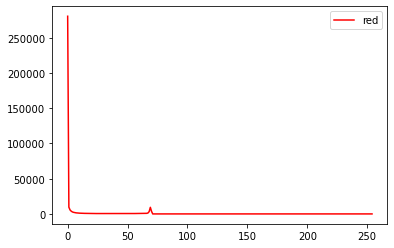

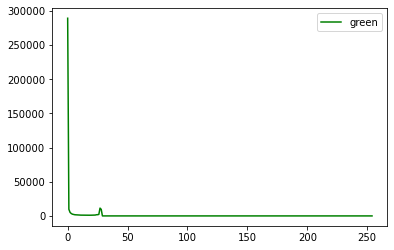

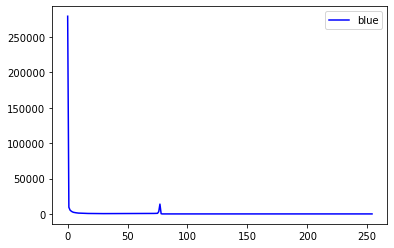

In [236]:
#Draw histo
seq_R = seq_average[:,:,0] 
seq_G = seq_average[:,:,1] 
seq_B = seq_average[:,:,2]

f_plot(arrayHist((seq_R * 255)), 'red', 'red')
f_plot(arrayHist((seq_G * 255)), 'green', 'green')
f_plot(arrayHist((seq_B * 255)), 'blue', 'blue')


## Now let's try to define a new borders for images. For each let's check from begin where is the first pixel different from 0 and also from the end.

In [264]:
def ret_non_zero_from_begin(seq):
    for x in range(len(seq)):
        if (seq[x] > 0):
            return int(x)
        else :
            if (x == len(seq)-1):
                return int(x)
def ret_non_zero_from_end(seq):
    for x in range(len(seq)-1,0,-1):
        if (seq[x] > 0):
            return int(x)
        else :
            if (x == 1):
                return int(x)

In [267]:
border_begin = np.zeros(600)
border_end = np.zeros(600)

for x in range (len(seq_average)):
    #begin
    R = seq_average[x,:,0]
    G = seq_average[x,:,1]
    B = seq_average[x,:,2]
    b_R = ret_non_zero_from_begin(R)
    b_G = ret_non_zero_from_begin(G)
    b_B = ret_non_zero_from_begin(B)
    
    b_p = max (b_R, b_G, b_B)
    border_begin[x] =b_p
    
    e_R = ret_non_zero_from_end(R)
    e_G = ret_non_zero_from_end(G)
    e_B = ret_non_zero_from_end(B)
    
    e_p = max (e_R, e_G,e_B)
    border_end[x] = e_p


In [277]:
print(border_begin[:100])
print(border_end[:100])

[599. 599. 599. 599. 599. 599. 599. 599. 599. 599. 599. 599. 599. 599.
 599. 599. 599. 599. 599. 599. 599. 599. 599. 599. 599. 599. 599. 599.
 599. 599. 599. 599. 599. 599. 599. 599. 599. 599. 599. 599. 599. 599.
 599. 599. 599. 599. 599. 599. 599. 599. 599. 599. 599. 599. 599. 599.
 599. 599. 599. 599. 599. 599. 599. 599. 599. 599. 599. 599. 599. 599.
 599. 599. 599. 599. 599. 599. 599. 599. 376. 361. 350. 343. 340. 338.
 333. 330. 328. 327. 326. 324. 321. 320. 318. 317. 316. 314. 313. 312.
 311. 309.]
[  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1. 380. 383. 386. 388. 390. 391.
 392. 393. 394. 394. 395. 396. 397. 398. 399. 400. 400. 401. 401.

In [ ]:

#Let's find left border 

left_border = min(border_begin) #output = 31
print('left border', left_border)
#Let's find right border

right_border = max(border_end) #output = 565
print ('right border', right_border)


#Let's find the upper border

u_b = -1
u_e = -1
for x in range(len(border_begin)):
    if (border_begin[x] != 599):
        u_b = x
        

for x in range(len(border_end)):
    if (border_end[x] != 1):
        u_e = x
        
upper_border = max(u_b, u_e)
print ('upper border', upper_border) #ouput is 531

#Let's find the lower border

l_b = -1
l_e = -1

for x in range(len(border_begin)-1,0,-1):
    if (border_begin[x] != 599):
        l_b = x
        

for x in range(len(border_end)-1,0,-1):
    if (border_end[x] != 1):
        l_e = x
        
lower_border = max(l_b, l_e)
print ('lower border', lower_border) #output is 78       

In [281]:
#Let's calcul the gain 

gain = (600*600) / ((565-31)*(531-78))
print('gain', gain)

gain 1.4882059677059305


### Neural Network

In [5]:
%pylab inline
#http://www.rricard.me/machine/learning/generative/adversarial/networks/keras/tensorflow/2017/04/05/gans-part2.html

import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, Conv1D, Dropout, ReLU, Flatten, Input, BatchNormalization, Reshape, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import sigmoid, tanh
from keras.losses import binary_crossentropy, mse
from keras.optimizers import SGD, Adam


from keras.utils import to_categorical

Populating the interactive namespace from numpy and matplotlib


C:\Users\cossa\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['tanh']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [6]:
 from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
# model = Sequential()
# model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(450,450,3)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64, (5, 5), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(1000, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(500, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(250, activation='relu'))
# model.add(Dense(1, activation='softmax'))


# model.compile(loss='categorical_crossentropy', 
#               optimizer='adam',
#               metrics=['accuracy'])

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(450, 450, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])



### Training

In [17]:
# import cv2
# import os

# def load_images_from_folder(folder):
#     images = []
#     for filename in os.listdir(folder):
#         img = cv2.imread(os.path.join(folder,filename))
#         if img is not None:
#             images.append(img)

#             return images

In [27]:
import os
def read_all_image_in_file(path_folder):
    x= []
    for file in os.listdir(path_folder):
        seq = imread(path_folder+file)
        x.append(seq)
    return x

   


In [11]:
###Filling up data
#number of images : 2586 (from 1 to 2586)
n = 2586
from skimage.io import imread

path = "C:\\Users\\cossa\\Documents\\ULB\\MA1\\Projet\\ProjetMA1\\C-NMC_Leukemia\\training_data\\fold_0\\"

path_all = "all\\" #2397 pictures label = 1
path_hem = "hem\\" #1130 pictures label = 0 

x_train_all1 = []
x_train_all2 = []

x_train_all1 = read_all_image_in_file(path + path_all)
x_train_all2 = read_all_image_in_file(path + path_hem)


x_train_all1_array = np.array(x_train_all1)
x_train_all2_array = np.array(x_train_all2)
print (x_train_all1_array.shape)
print (x_train_all2_array.shape)


(2397, 450, 450, 3)
(1130, 450, 450, 3)


In [12]:
y_train_all1 = np.ones(x_train_all1_array.shape[0])
y_train_all2 = np.zeros(x_train_all2_array.shape[0])
print (y_train_all1.shape)
print (y_train_all2.shape)

x_concatenate = np.concatenate((x_train_all1_array,x_train_all2_array))
y_concatenate = np.concatenate((y_train_all1, y_train_all2))

print(x_concatenate.shape)
print(y_concatenate.shape)

(2397,)
(1130,)
(3527, 450, 450, 3)
(3527,)


In [13]:
hist = model.fit(x_concatenate, y_concatenate, batch_size=256, epochs=10, validation_split=0.2 )

Epoch 1/10
12/12 [==============================] - 738s 62s/step - loss: 32.3119 - accuracy: 0.6831 - val_loss: 2.1062 - val_accuracy: 0.0156
Epoch 2/10
 1/12 [=>............................] - ETA: 0s - loss: 0.3703 - accuracy: 0.8438

KeyboardInterrupt: 

In [19]:
x_test = x_train_all1_array[50]
print(x_test.shape)

(450, 450, 3)


In [21]:
y= model.predict(x_train_all1_array)


In [26]:
import sys
np.set_printoptions(threshold=sys.maxsize)
print(y)
print (np.sum(y)/len(y)) #96% acc

[[0.99980044]
 [0.999972  ]
 [0.9999261 ]
 [0.99994445]
 [0.993325  ]
 [0.9999832 ]
 [0.998549  ]
 [0.9977723 ]
 [0.9996292 ]
 [0.9998592 ]
 [0.999975  ]
 [0.97295535]
 [0.99953616]
 [0.64157283]
 [0.99925363]
 [0.9984074 ]
 [0.99992704]
 [0.99984455]
 [0.9970577 ]
 [0.9984924 ]
 [0.94522583]
 [0.9999057 ]
 [0.99996424]
 [0.997864  ]
 [0.9967892 ]
 [0.9994018 ]
 [0.9856436 ]
 [0.9990127 ]
 [0.99907255]
 [0.9999678 ]
 [0.9034718 ]
 [0.9998604 ]
 [0.9996388 ]
 [0.99966145]
 [0.9993213 ]
 [0.99889517]
 [0.9999842 ]
 [0.9999838 ]
 [0.9996331 ]
 [0.99988294]
 [0.9987579 ]
 [0.674848  ]
 [0.9998269 ]
 [0.99947196]
 [0.8847928 ]
 [0.9999691 ]
 [0.9984387 ]
 [0.99378026]
 [0.9999963 ]
 [0.99950695]
 [0.999907  ]
 [0.999699  ]
 [0.99999344]
 [0.9994495 ]
 [0.9999799 ]
 [0.9999807 ]
 [0.99995375]
 [0.8895578 ]
 [0.99748176]
 [0.9998045 ]
 [0.9907292 ]
 [0.99998975]
 [0.99999565]
 [0.9999985 ]
 [0.9997902 ]
 [0.9999807 ]
 [0.99994624]
 [0.99998987]
 [0.99998283]
 [0.99996555]
 [0.9999924 ]
 [0.99

In [42]:
path = "C:\\Users\\cossa\\Documents\\ULB\\MA1\\Projet\\ProjetMA1\\C-NMC_Leukemia\\training_data\\fold_2\\"

path_all = "all\\" #2397 pictures label = 1
path_hem = "hem\\" #1130 pictures label = 0 
x_verif = read_all_image_in_file(path + path_all)



In [43]:
x_verif = np.array(x_verif)

In [ ]:
y_verif = model.predict(x_verif)

In [ ]:
print(y_verif)
print (np.sum(y_verif)/len(y_verif)) #97.15% acc

In [36]:
x_verif_hem =np.array(read_all_image_in_file(path + path_hem))
print(x_verif_hem.shape)

(1163, 450, 450, 3)


In [37]:
y_verif_hem = model.predict(x_verif_hem)

In [38]:
print(y_verif_hem)
print (np.sum(y_verif_hem)/len(y_verif_hem)) #73% acc

[[0.9488218 ]
 [0.8892118 ]
 [0.97777605]
 [0.9604275 ]
 [0.9788681 ]
 [0.53630406]
 [0.5483307 ]
 [0.6629781 ]
 [0.99119604]
 [0.9124051 ]
 [0.77629924]
 [0.5065798 ]
 [0.99976754]
 [0.50199854]
 [0.5220286 ]
 [0.50199854]
 [0.5752132 ]
 [0.8047329 ]
 [0.50471485]
 [0.85958564]
 [0.9648198 ]
 [0.9997306 ]
 [0.507956  ]
 [0.5438781 ]
 [0.9971959 ]
 [0.9911149 ]
 [0.76401895]
 [0.99832684]
 [0.8585683 ]
 [0.6364425 ]
 [0.73783016]
 [0.50199854]
 [0.704929  ]
 [0.61340964]
 [0.73368126]
 [0.9966457 ]
 [0.97786754]
 [0.9999927 ]
 [0.5297454 ]
 [0.9960164 ]
 [0.99999785]
 [0.9999999 ]
 [0.8587981 ]
 [0.9996401 ]
 [0.9993125 ]
 [0.9962456 ]
 [0.54212433]
 [0.9999395 ]
 [0.9695091 ]
 [0.99994016]
 [0.9503626 ]
 [0.8003945 ]
 [0.50199854]
 [0.8326299 ]
 [0.6495919 ]
 [0.9796238 ]
 [0.95326054]
 [0.5313726 ]
 [0.50199854]
 [0.9967507 ]
 [0.94597983]
 [0.63539296]
 [0.5033526 ]
 [0.50199854]
 [0.86351126]
 [0.6939089 ]
 [0.94627154]
 [0.99535084]
 [0.5285549 ]
 [0.53449917]
 [0.5238059 ]
 [0.51

# TODO 

* Tout d'abord choisir un meilleur modèle. (Voir pourquoi  il faut passer plusieurs images pour que le modèle fonctionne)
* Load toutes leus images de tests pour chaque folder. 
* Instaler le GPU - Créer un nouvel environnement python dedié au machine learning 
* Run le tout et tester les résultats. 

# Si les résultats ne sont pas concluants 

* Améliorer le modèle
* Mettre en place le pre-processing pour réduire la taille de l'image et gagner en temps, permettant d'améliorer le modèle. 
* Recalculer une image moyenne pour chaque type de cellule -> plot histogramme 

-> Chercher des facteurs discriminants (les pics d'énergie liées à R, G, B?) 

* Rajouter ces facteurs discriminants dans le modèle